# **Sentiment Analysis - Indodax**

> **Name:** Alessandro Ryo

---
## Project Prerequisites

### Indonesian Multi-phase Stemmer: A Stemming Algorithm for Indonesian Language

This stemmer is designed specifically for the Indonesian language, capable of handling both formal (baku) and informal (non-baku) words. The core algorithm is inspired by the work of Adriani et al. (2007), but has been adapted and enhanced to address the complexities of Indonesian morphology.

#### Installation

To install the `MPStemmer` library, use the following command:

In [2]:
!pip install --upgrade git+https://github.com/ariaghora/mpstemmer.git

DEPRECATION: Loading egg at d:\software\python\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Running command git clone --filter=blob:none --quiet https://github.com/ariaghora/mpstemmer.git 'C:\Users\Alessandro Ryo\AppData\Local\Temp\pip-req-build-097rc7yt'


  Cloning https://github.com/ariaghora/mpstemmer.git to c:\users\alessandro ryo\appdata\local\temp\pip-req-build-097rc7yt
  Resolved https://github.com/ariaghora/mpstemmer.git to commit 25a5fd923af163a7eac3a5ec976984156ca8fa8b
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


&nbsp;

### Import Project Libraries

This section covers the import of essential libraries needed for data preprocessing, modeling, and evaluation in the project. Each imported library plays a crucial role in handling various tasks such as data manipulation, text processing, model building, and evaluation.

In [3]:
import os
import re
import csv
import requests
import emoji
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from mpstemmer import MPStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, SimpleRNN
from tensorflow.keras import Input
from tensorflow.keras.callbacks import Callback

### NLTK Installation

In [4]:
def ensure_directory_exists(directory):
    """
    Ensures that the specified directory exists.
    If the directory does not exist, it will be created.
    """
    os.makedirs(directory, exist_ok=True)
    # Create the directory if it doesn't already exist, using 'exist_ok=True' to avoid errors if the directory is already present.

In [5]:
# Ensure the 'data' directory exists
ensure_directory_exists('data')

# Add the 'data' directory path to NLTK
nltk.data.path.append(os.path.abspath('data'))

# Download necessary datasets if not already available
if not nltk.data.find('tokenizers/punkt'):
    nltk.download('punkt', download_dir='data')  # Dataset for text tokenization

if not nltk.data.find('corpora/stopwords'):
    nltk.download('stopwords', download_dir='data')  # Stopwords dataset for various languages

- **Creating the `data` Directory**:<br>
  Ensures the existence of the `data` directory by using the `ensure_directory_exists` function. If the directory doesn't already exist, it will be created.

- **Adding the `data` Path to NLTK**:<br>
  Appends the path of the `data` directory to NLTK's search paths, enabling NLTK to store and access necessary datasets in this directory.

- **Downloading the `punkt` Dataset**:<br>
  Checks if the `punkt` dataset, used for text tokenization, is already available. If not, the dataset is downloaded to the `data` directory.

- **Downloading the `stopwords` Dataset**:<br>
  Verifies whether the `stopwords` dataset is present. If it's missing, the dataset is downloaded to the `data` directory.

#### *Requirements.txt* 

In [6]:
# Generate requirements.txt in the current directory
!pip freeze > requirements.txt

DEPRECATION: Loading egg at d:\software\python\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


---
## Import Data and Initial Inspection

##### *Load Data*

In [9]:
# Load data from the CSV file into a DataFrame
df = pd.read_csv('data/review.csv')

##### *Initial Information*

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49320 entries, 0 to 49319
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  49319 non-null  object
dtypes: object(1)
memory usage: 385.4+ KB


In [11]:
df.head()

,content
0,"Asli ini aplikasi tambah bulan makin ok, serin..."
1,"Aplikasi Indodax tampilannya semakin bagus, & ..."
2,"saya pengguna awal di aplikasi indodax, untuk ..."
3,"Aplikasinya bagus, mudah banget untuk digunaka..."
4,Aplikasi IDODAX ini sangat mudah di gunakan da...


---
## Data Preprocessing and Preparation

##### *Data Cleaning*

In [12]:
# Remove rows containing null values
df = df.dropna()

# Remove duplicate rows
df = df.drop_duplicates()

- **Removing Rows Containing Null Values**:
  - **Code**: `df = df.dropna()`
  - **Description**: This operation removes all rows in the DataFrame `df` that contain `NaN` (Not a Number) or null values. Null values often appear in incomplete or missing datasets, and they can cause issues during analysis if not addressed. By removing rows with null values, the DataFrame becomes more consistent and ready for analysis.

- **Removing Duplicate Rows**:
  - **Code**: `df = df.drop_duplicates()`
  - **Description**: This operation removes all duplicate rows in the DataFrame `df`, keeping only one unique row for each set of duplicate data. Duplicates may occur due to errors in data collection or previous processing steps. Removing duplicates helps ensure that each data point in the DataFrame appears only once, thus preventing any potential bias or redundancy in the analysis.

### Text Pre-Processing Functions

#### Clean Text

In [13]:
def clean_text(text):
    """
    Cleans the text from non-text characters, including numbers, symbols, and emojis,
    replacing them with spaces, and then removes any excessive spaces.

    Parameters:
        text (str): The text that will be cleaned.

    Returns:
        str: The cleaned text.
    """
    # Replace all characters except letters and spaces with a space
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove all numbers
    text = re.sub(r'\d+', ' ', text)
    
    # Replace all emojis with a space
    text = emoji.replace_emoji(text, replace=' ')
    
    # Remove excessive spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

- **Goal**:  
  The `clean_text` function is designed to sanitize text by removing non-text characters, including numbers, symbols, and emojis. It replaces these characters with spaces and eliminates excessive spaces to create a clean, uniform text string suitable for further text processing tasks such as natural language processing (NLP) or sentiment analysis.

- **Parameters**:  
  - `text (str)`: The raw text string that requires cleaning.

- **Process**:  
  - **Character Replacement**: Non-text characters, including punctuation, symbols, and emojis, are identified and replaced with spaces.
  - **Number Removal**: All numeric characters are removed from the text.
  - **Emoji Replacement**: Any emoji present in the text is replaced with a space.
  - **Space Normalization**: Consecutive spaces are reduced to a single space, and leading or trailing spaces are removed to tidy up the text.

- **Return**:  
  - The function returns the cleaned text as a string (`str`) with only letters and spaces, ensuring the text is in a consistent format for further analysis.

#### Lowercase Text

In [14]:
def lowercase_text(text):
    """
    Converts all characters in the given text to lowercase.

    Parameters:
        text (str): The text that will be converted to lowercase.

    Returns:
        str: The text with all characters converted to lowercase.
    """
    return text.lower()

- **Goal**:  
  The function `lowercase_text` is intended to standardize the text by converting all characters to lowercase. This process ensures consistency in text data, which is crucial for avoiding discrepancies in tasks such as text comparison, text analysis, or sentiment analysis where case sensitivity might impact the results.

- **Parameters**:  
  - `text (str)`: The input text string that needs to be converted to lowercase.

- **Process**:  
  - The function uses the `.lower()` method to convert all uppercase letters in the input text to lowercase, leaving other characters unchanged.

- **Return**:  
  - The function returns the processed text as a string (`str`) with all characters in lowercase.

#### Replace Slang Words

In [15]:
def replace_slang_words(text):
    """
    Replaces slang words in the text with their standard equivalents based on a predefined dictionary.

    Parameters:
        text (str): The text containing slang words that need to be replaced.

    Returns:
        str: The text with slang words replaced by their standard equivalents.
    """
    # Dictionary of slang words and their standard equivalents
    slangwords = {
        '@': 'di', 'apk': 'aplikasi', 'abis': 'habis', 'bnr': 'benar', 'bgt': 'banget', 'btw': 'ngomong-ngomong', 
        'cmiiw': 'jika saya tidak salah', 'dong': 'tolong', 'dpt': 'dapat', 'ga': 'tidak', 'gak': 'tidak', 
        'gini': 'begini', 'gitu': 'begitu', 'gua': 'saya', 'gue': 'saya', 'hny': 'hanya', 'hrs': 'harus', 
        'kalo': 'kalau', 'kan': 'bukan', 'kayak': 'seperti', 'krn': 'karena', 'loh': 'loh', 
        'mlm': 'malam', 'nih': 'ini', 'pd': 'pada', 'pke': 'pakai', 'sbm': 'sebelum', 'sdh': 'sudah', 
        'sih': 'sih', 'sy': 'saya', 'tdk': 'tidak', 'tuh': 'itu', 'udh': 'sudah', 'wkwk': 'tertawa', 
        'wkwkwk': 'tertawa', 'wtb': 'ingin membeli', 'wts': 'ingin menjual', 'wtt': 'ingin menukar', 
        'males': 'malas', 'yg': 'yang'
    }
    
    # Split the text into individual words
    words = text.split()
    
    # Replace slang words with their standard equivalents
    return ' '.join([slangwords.get(word.lower(), word) for word in words])

- **Goal**: <br>
  The `replace_slang_words` function is designed to replace slang words in a text with their corresponding standard equivalents. This ensures that the text is more formal and standardized, making it suitable for various types of text processing and analysis.

- **Parameters**:
  - `text (str)`: The input text that may contain slang words.

- **Process**:
  - **Slang Dictionary**: A predefined dictionary of slang words and their standard equivalents is used.
  - **Text Splitting**: The input text is split into individual words.
  - **Replacement**: Each word in the text is checked against the slang dictionary, and if a match is found, it is replaced with the standard equivalent.
  - **Reconstruction**: The modified words are joined back together to form the cleaned text.

- **Return**:
  - The function returns the cleaned text as a string (`str`), where all recognized slang words have been replaced with their formal equivalents.

#### Tokenize Text

In [16]:
def tokenize_text(text):
    """
    Splits the input text into a list of tokens (words).

    Parameters:
        text (str): The text to be tokenized.

    Returns:
        list: A list of tokens extracted from the input text.
    """
    # Perform text tokenization
    text = word_tokenize(text)
    
    return text

- **Goal**:
  The `tokenize_text` function is designed to split a string of text into a list of individual tokens (words). This is a critical step in text preprocessing for natural language processing tasks.

- **Parameters**:
  - `text (str)`: The input text that needs to be tokenized.

- **Process**:
  - The input text is passed through a tokenization process, where it is split into individual words or tokens.
  - This process typically uses a tokenizer, such as the `word_tokenize` function from NLTK, which handles splitting based on spaces and punctuation.

- **Return**:
  - The function returns a list (`list`) of tokens, where each token is a word or a sequence of characters extracted from the input text.

#### Remove Stopwords

In [17]:
def remove_stopwords(text):
    """
    Removes stopwords from a list of tokens and returns the filtered tokens without stopwords.

    Parameters:
        text (list): The list of tokens to be filtered.

    Returns:
        list: The list of tokens after stopwords have been removed.
    """  
    # Retrieve stopwords from the Indonesian language, and add additional custom stopwords
    stopword_lists = set(stopwords.words('indonesian'))
    additional_stopwords = {
        'abis', 'ada', 'adalah', 'agak', 'aja', 'anjay', 'atau', 'banget', 'bangettt', 'benar', 'biar', 'bikin', 
        'dah', 'dikit', 'dong', 'enggak', 'gak', 'gitu', 'gituan', 'gua', 'gue', 'iya', 'juga', 'kalo', 'kayak', 
        'kayaknya', 'ko', 'kok', 'ku', 'lah', 'lagi', 'lho', 'loh', 'mah', 'mau', 'mereka', 'mesti', 'na', 'nah', 'nanti', 'nih', 
        'nya', 'ok', 'oke', 'pas', 'pasti', 'seperti', 'sih', 'tau', 'tidak', 'tuh', 'udah', 'wow', 'woy', 'ya', 'yaa', 'yang', 'yuk'
    }
    stopword_lists.update(additional_stopwords)
    
    # Remove stopwords from the list of tokens
    filtered_text = [word for word in text if word.lower() not in stopword_lists]
    
    return filtered_text

- **Goal**:
  The `remove_stopwords` function is designed to filter out common stopwords from a list of tokens. Stopwords are frequent words that usually do not carry significant meaning, such as "and," "the," or "but," and are removed to improve the quality of text analysis.

- **Parameters**:
  - `text (list)`: A list of tokens (words) from which stopwords will be removed.

- **Process**:
  - The function retrieves a predefined list of stopwords from the Indonesian language using the NLTK library.
  - Additional custom stopwords are added to the stopwords list to cover specific cases relevant to the dataset.
  - The function iterates through each token in the input list and filters out any word that is present in the stopwords list.

- **Return**:
  - The function returns a list (`list`) of tokens that no longer include any stopwords, making the remaining words more meaningful for further analysis.

#### Lemmatization Text

In [18]:
def lemmatize_text(text):
    """
    Applies lemmatization or stemming to a list of tokens using MPStemmer.

    Parameters:
        text (list): A list of words (tokens) to be lemmatized or stemmed.

    Returns:
        list: A list of words (tokens) that have been lemmatized or stemmed.
    """
    # Initialize the MPStemmer object for lemmatization or stemming
    stemmer = MPStemmer()
    
    # Apply lemmatization or stemming to each word in the list
    stemmed_text = [stemmer.stem(token) for token in text]
    
    return stemmed_text

- **Goal**:
  The `lemmatize_text` function is designed to reduce words in a list of tokens to their base or root form using the MPStemmer, a tool specifically for Indonesian text. This process helps to normalize words, making them more consistent for analysis.

- **Parameters**:
  - `text (list)`: A list of words (tokens) that will undergo lemmatization or stemming.

- **Process**:
  - The function initializes an MPStemmer object, which is configured to process Indonesian language text.
  - Each token in the list is processed through the `stem` method of the MPStemmer, which reduces the word to its root form.

- **Return**:
  - The function returns a list (`list`) of words that have been lemmatized or stemmed. This results in a standardized text that is easier to analyze in tasks such as sentiment analysis, topic modeling, or other natural language processing (NLP) applications.

#### Merge to Sentence

In [19]:
def join_tokens(tokens):
    """
    Joins a list of tokens into a single text string, with spaces separating the tokens.

    Parameters:
        tokens (list): A list of words (tokens) that need to be joined into a string.

    Returns:
        str: A single string where all the tokens are combined with a space separating each token.
    """
    # Combine the list of tokens into one string, with spaces as the separator
    return ' '.join(tokens)

- **Goal**:
  The `join_tokens` function is designed to combine a list of words (tokens) into a single text string, with spaces separating each token. This is typically done after tokenization, stopword removal, or other text preprocessing steps, to return the tokens to a readable text format.

- **Parameters**:
  - `tokens (list)`: A list of words (tokens) that are to be combined into a single string.

- **Process**:
  - The function uses Python's `join` method to concatenate all elements in the `tokens` list into one string, placing a space between each word.

- **Return**:
  - The function returns a string (`str`) where all tokens are combined, ensuring that the resulting text is properly spaced and formatted for further processing or analysis.

### Text Pre-Processing Implementation

In [20]:
# Clean the text and store it in the 'clean_text' column
df['clean_text'] = df['content'].apply(clean_text)

# Convert the text to lowercase and store it in the 'lowercase_text' column
df['lowercase_text'] = df['clean_text'].apply(lowercase_text)

# Replace slang words with standard words and store the result in the 'slang_replaced_text' column
df['slang_replaced_text'] = df['lowercase_text'].apply(replace_slang_words)

# Tokenize the text and store the tokens in the 'tokenized_text' column
df['tokenized_text'] = df['slang_replaced_text'].apply(tokenize_text)

# Remove stopwords and store the cleaned tokens in the 'no_stopwords_text' column
df['no_stopwords_text'] = df['tokenized_text'].apply(remove_stopwords)

# Apply lemmatization to the tokens and store the result in the 'lemmatized_text' column
df['lemmatized_text'] = df['no_stopwords_text'].apply(lemmatize_text)

# Join the tokens back into a sentence and store the result in the 'final_clean_text' column
df['final_clean_text'] = df['lemmatized_text'].apply(join_tokens)

- **Text Cleaning**:
  - The `clean_text` function is utilized to:
    - Remove non-text characters such as numbers, symbols, and emojis.
    - Replace these characters with spaces.
    - Eliminate any excessive spaces in the text.
  - The cleaned text is then stored in the `clean_text` column.

- **Text Lowercasing**:
  - The `lowercase_text` function is used to:
    - Convert all characters in the text to lowercase to maintain consistency.
  - The lowercased text is saved in the `lowercase_text` column.

- **Slang Replacement**:
  - The `replace_slang_words` function works to:
    - Identify and replace any slang terms with their standard equivalents.
  - The modified text is stored in the `slang_replaced_text` column.

- **Text Tokenization**:
  - The `tokenize_text` function is applied to:
    - Break the text into individual words (tokens).
  - These tokens are stored in the `tokenized_text` column.

- **Stopword Removal**:
  - The `remove_stopwords` function is employed to:
    - Remove common stopwords from the list of tokens to retain only meaningful words.
  - The cleaned tokens are saved in the `no_stopwords_text` column.

- **Text Lemmatization**:
  - The `lemmatize_text` function is responsible for:
    - Reducing words to their base or dictionary forms (lemmas).
  - The results are stored in the `lemmatized_text` column.

- **Token Joining**:
  - The `join_tokens` function is used to:
    - Reassemble the tokens into a single coherent string of text.
  - This final cleaned text is saved in the `final_clean_text` column.

### Export Processed Dataframe

##### *List to String*

In [21]:
def list_to_string(lst):
    """
    Converts a list of elements into a string representation without enclosing elements in quotes.

    Parameters:
        lst (list): A list of strings that need to be converted into a string format.

    Returns:
        str: A string that represents the list, with elements separated by a comma and space,
             enclosed within square brackets, and without quotes around the individual elements.
    """
    # Combine the list elements into a single string, separated by commas and enclosed in brackets
    return '[' + ', '.join(lst) + ']'

- **Goal**:
  - The `list_to_string` function is designed to convert a list of strings into a single string representation. This string includes the elements separated by commas and spaces, enclosed within square brackets, and without quotes around the individual elements.

- **Parameter**:
  - `lst (list)`: The function takes a list of strings as input, which it will convert into a formatted string.

- **Process**:
  - The elements of the list are joined into a single string, with each element separated by a comma and a space. 
  - The resulting string is then enclosed within square brackets to resemble a Python list, but without the typical quotation marks around string elements.

- **Return**:
  - The function returns a string that represents the list in a readable format, ideal for storing or displaying the list in a more compact and aesthetically pleasing way.

In [22]:
# Apply the list_to_string function to encode columns before saving to CSV
df['tokenized_text'] = df['tokenized_text'].apply(list_to_string)
df['no_stopwords_text'] = df['no_stopwords_text'].apply(list_to_string)
df['lemmatized_text'] = df['lemmatized_text'].apply(list_to_string)

In [23]:
# Drop rows that contain any null values in any column
df = df.dropna()

- **Reason for Dropping Rows with Null Values**:
  - After performing several preprocessing steps, some rows may end up with null values in one or more columns. 
  - These null values could result from operations like tokenization, lemmatization, or removing stopwords, where certain rows might be reduced to empty strings or contain no valid data after cleaning.

##### *Export*

In [24]:
# Export to CSV file
df.to_csv('./data/processed_review.csv', index=False)

In [25]:
# Drop rows that contain any null values in any column
df = df.dropna()

---
## Loading the Processed DataFrame

##### *Import*

In [26]:
# Load the processed dataset directly from a CSV file
df = pd.read_csv('data/processed_review.csv')

- **Loading the Processed Dataset**:
  - This line of code reads a previously processed dataset from a CSV file named `'processed_review.csv'` located in the `'data'` directory.
  
- **Purpose**:
  - Loading the processed dataset directly is an efficient way to save time, as it eliminates the need to perform text preprocessing steps like cleaning, tokenization, and lemmatization again.

- **Advantage**:
  - This approach is particularly useful when the preprocessing has already been completed and saved, allowing for quick and direct access to the data for further analysis or modeling tasks.

##### *Convert String to List*

In [27]:
def string_to_list(string):
    """
    Converts a string representation of a list into an actual list object.

    Parameters:
        string (str): The string that represents a list (e.g., '[item1, item2, item3]').

    Returns:
        list: A list object containing the items from the string.
    """
    # Remove the square brackets and split the string by commas
    items = string.strip('[]').split(', ')
    
    # Return the list of items without changing their format
    return items

- **Goal**:
  - The `string_to_list` function is designed to convert a string that visually represents a list (e.g., `'[item1, item2, item3]'`) into an actual Python list object. This is useful when dealing with data that was stored or transferred as a string but needs to be processed as a list.

- **Parameter**:
  - `string (str)`: The input string that visually represents a list, including square brackets and items separated by commas.

- **Process**:
  - The function first removes the square brackets (`[ ]`) from the string.
  - Then, it splits the string by commas to separate the items, effectively creating a list of those items.

- **Return**:
  - The function returns a list (`list`) of items that were originally represented as a string. This list can then be used for further processing or analysis.

In [28]:
# Apply the parsing function to the necessary columns
df['tokenized_text'] = df['tokenized_text'].apply(string_to_list)
df['no_stopwords_text'] = df['no_stopwords_text'].apply(string_to_list)
df['lemmatized_text'] = df['lemmatized_text'].apply(string_to_list)

- **Goal**:
  - The purpose of this code block is to convert string representations of lists back into actual list objects for specific columns in the DataFrame. This is necessary after reading the processed data from a CSV file where the lists were stored as strings.

- **Process**:
  - **Applying the `string_to_list` Function**:
    - The `string_to_list` function is applied to each entry in the `tokenized_text`, `no_stopwords_text`, and `lemmatized_text` columns.
    - This function converts each string that looks like a list into a real Python list.
  
- **Result**:
  - The specified columns in the DataFrame (`tokenized_text`, `no_stopwords_text`, `lemmatized_text`) now contain lists instead of strings, making the data ready for further processing or analysis.

---
## Data Labeling

##### *Fetch Lexicon*

In [29]:
def fetch_lexicon(url):
    """
    Fetches lexicon data from a CSV file available at a given URL and returns it as a dictionary.

    Parameters:
        url (str): The URL of the CSV file containing the lexicon data.

    Returns:
        dict: A dictionary where the keys are words and the values are their corresponding sentiment scores.
    """
    lexicon = dict()
    response = requests.get(url)
    
    if response.status_code == 200:
        # Use tab as the delimiter since the CSV file from InSet uses tab-separated values
        reader = csv.reader(StringIO(response.text), delimiter='\t')  
        next(reader)  # Skip the header row if present
        for row in reader:
            lexicon[row[0]] = int(row[1])
    else:
        print(f"Failed to fetch lexicon data from {url}")
    
    return lexicon

# URLs for positive and negative lexicons from the InSet dataset
url_positive = 'https://raw.githubusercontent.com/fajri91/InSet/master/positive.tsv'
url_negative = 'https://raw.githubusercontent.com/fajri91/InSet/master/negative.tsv'

# Fetch positive and negative lexicon data
lexicon_positive = fetch_lexicon(url_positive)
lexicon_negative = fetch_lexicon(url_negative)

- **Goal**:
  - The objective of this code is to retrieve sentiment lexicon data from specific URLs and store it as dictionaries. This lexicon data is useful for performing sentiment analysis on text data.

- **Process**:
  - **Fetching Lexicon Data**:
    - The `fetch_lexicon` function is responsible for sending an HTTP GET request to the provided URL. If the request is successful (status code 200), it reads the CSV content.
    - The CSV file is expected to use tabs as delimiters (`\t`), which is typical for TSV (Tab-Separated Values) files.
    - The first row of the file is skipped as it usually contains headers.
    - Each subsequent row is processed into a key-value pair in the dictionary, where the key is the word and the value is its sentiment score.
  
- **Result**:
  - Two dictionaries, `lexicon_positive` and `lexicon_negative`, are created. These dictionaries contain words as keys and their corresponding sentiment scores as values, which can later be used to analyze text sentiment.

##### *Sentiment Analysis*

In [30]:
def analyze_sentiment_indonesian(text):
    """
    Analyzes the sentiment of the given text by calculating a score based on positive and negative sentiment lexicons.
    Returns the sentiment score and its corresponding polarity (positive, negative, or neutral).
    
    Parameters:
        text (list): A list of words (tokens) from the text that needs sentiment analysis.
        
    Returns:
        tuple: A tuple containing the sentiment score and the polarity as a string ('positive', 'negative', 'neutral').
    """
    # Calculate the sentiment score by summing up the values from both positive and negative lexicons
    score = sum(lexicon_positive.get(word, 0) + lexicon_negative.get(word, 0) for word in text)
    
    # Determine the polarity based on the sentiment score
    if score > 0:
        return score, 'positive'  # Return positive if the score is greater than 0
    elif score < 0:
        return score, 'negative'  # Return negative if the score is less than 0
    else:
        return score, 'neutral'   # Return neutral if the score is exactly 0

- **Goal**:
  - The goal of the `analyze_sentiment_indonesian` function is to evaluate the sentiment of a given text by leveraging predefined sentiment lexicons. The function calculates a sentiment score and assigns a corresponding polarity (positive, negative, or neutral).

- **Process**:
  - **Sentiment Scoring**:
    - The function takes a list of words (tokens) and iterates through each word.
    - For each word, it looks up its sentiment score in both the positive (`lexicon_positive`) and negative (`lexicon_negative`) lexicons.
    - If the word exists in the lexicon, its associated score (positive or negative) is added to the overall sentiment score.
  
  - **Determining Polarity**:
    - After calculating the total sentiment score:
      - If the score is greater than zero, the text is classified as 'positive'.
      - If the score is less than zero, the text is classified as 'negative'.
      - If the score is exactly zero, the text is considered 'neutral'.
  
- **Return**:
  - The function returns a tuple containing the sentiment score and the corresponding polarity as a string ('positive', 'negative', or 'neutral').

In [31]:
# Apply the analyze_sentiment_indonesian function to each row in the 'lemmatized_text' column
sentiment_results = df['lemmatized_text'].apply(analyze_sentiment_indonesian)

# Split the results into two separate columns: 'polarity_score' and 'polarity'
df[['polarity_score', 'polarity']] = pd.DataFrame(sentiment_results.tolist(), index=df.index)

# Display the distribution of the polarity values to understand the sentiment spread
df['polarity'].value_counts()

polarity
negative    16174
positive    15194
neutral      6958
Name: count, dtype: int64

---
## Visualization

This section focuses on visually representing the sentiment analysis results through the creation of pie charts and word clouds. The pie charts will provide a clear breakdown of the distribution of sentiment categories (positive, negative, and neutral) within the dataset. Meanwhile, word clouds will be used to highlight the most frequently occurring words in each sentiment category, offering insights into the key themes and topics that dominate the reviews. These visualizations are crucial for understanding the overall sentiment and the specific language patterns associated with different sentiments.

### *Pie Chart*

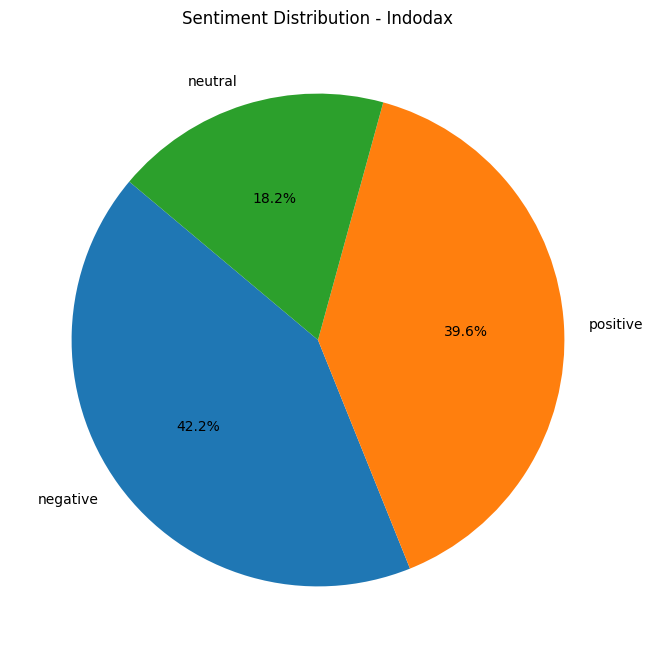

In [32]:
# Sample data for polarity counts
polarity_counts = df['polarity'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution - Indodax')
plt.show()

### *Word Clouds*

In [33]:
# Define a function to generate a word cloud for any given text and polarity
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

- **Purpose**: The `generate_wordcloud` function is created to visualize text data by generating a word cloud. This visualization technique helps in identifying the most frequently occurring words in the dataset.

- **Parameters**:
  - `text`: This is the input text data that will be used to generate the word cloud. It typically represents a large body of text.
  - `title`: This is the title of the word cloud plot. It provides context for the visualization, making it easier to interpret.

- **Process**:
  1. **Word Cloud Generation**: The function utilizes the `WordCloud` class to create a word cloud with a specified width, height, and a white background. The word cloud is generated based on the frequency of words in the `text`.
  2. **Visualization**: The generated word cloud is then displayed using `matplotlib`. The plot is rendered without axis labels for a cleaner look, and the provided `title` is added to the top of the plot.

- **Usage**: This function is useful for exploring the most prominent words in textual data, offering a quick and visually appealing way to grasp key themes and patterns within the text.

In [34]:
# Ensure all entries in 'final_clean_text' are strings
df['final_clean_text'] = df['final_clean_text'].astype(str)

# Combine texts for each sentiment
general_text = ' '.join(df['final_clean_text'])
positive_text = ' '.join(df[df['polarity'] == 'positive']['final_clean_text'])
negative_text = ' '.join(df[df['polarity'] == 'negative']['final_clean_text'])
neutral_text = ' '.join(df[df['polarity'] == 'neutral']['final_clean_text'])

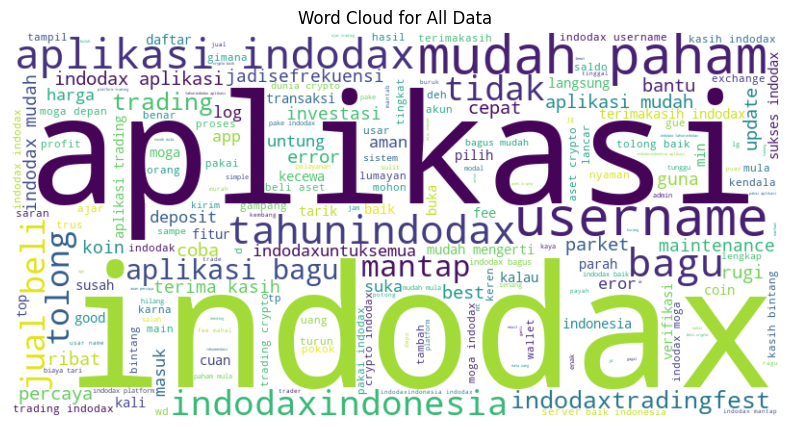

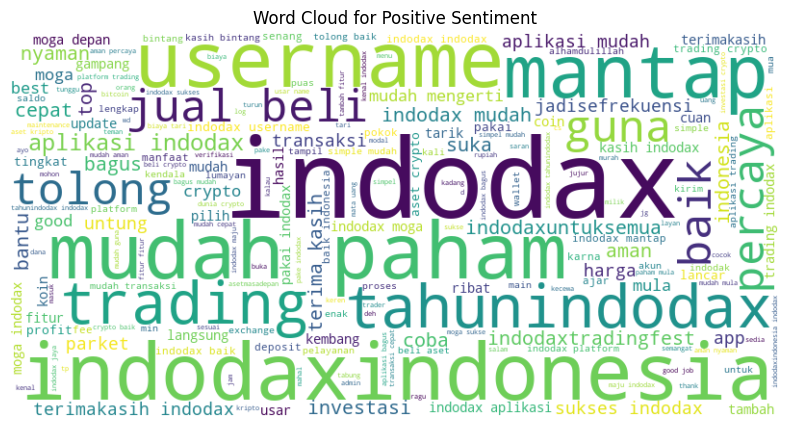

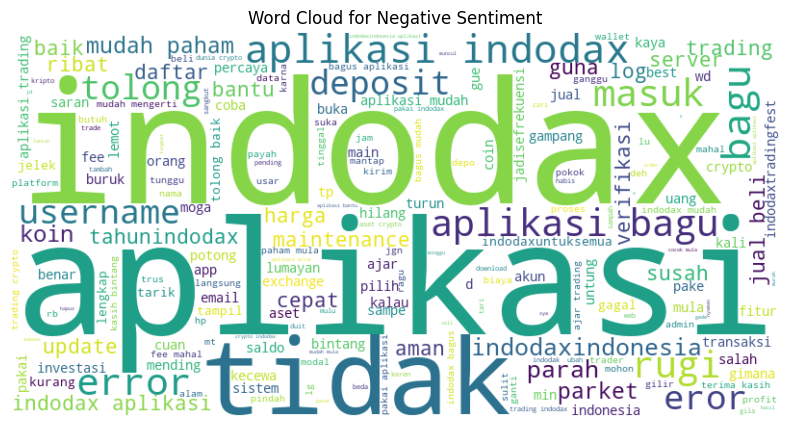

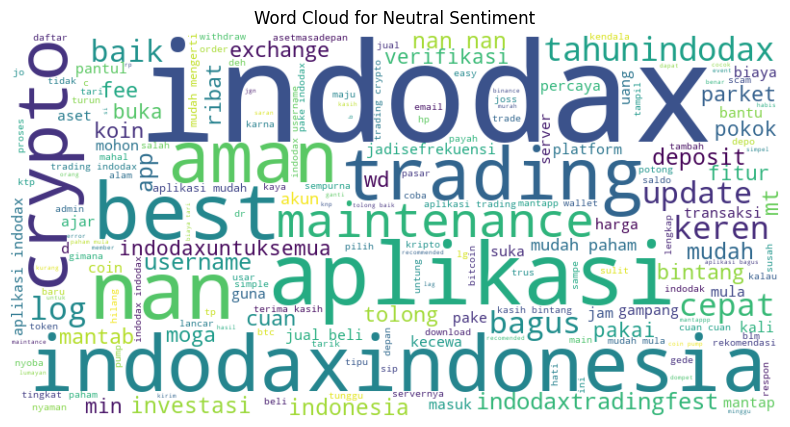

In [35]:
# Generate word clouds for each sentiment category
generate_wordcloud(general_text, "Word Cloud for All Data")
generate_wordcloud(positive_text, "Word Cloud for Positive Sentiment")
generate_wordcloud(negative_text, "Word Cloud for Negative Sentiment")
generate_wordcloud(neutral_text, "Word Cloud for Neutral Sentiment")

---
## Feature Extraction and Modeling

- **Combination 1: MLP + TF-IDF**
  - **Feature Extraction**:
    - **TF-IDF (Term Frequency-Inverse Document Frequency)**: Converts text into numerical vectors by measuring the importance of a word in a document relative to its frequency across the entire dataset. This method emphasizes words that are frequent in a particular document but rare across the entire corpus.
  - **Model**:
    - **Multilayer Perceptron (MLP)**: A type of feedforward neural network composed of multiple layers of fully connected neurons. This architecture is well-suited for handling numerical feature vectors and is commonly used for classification tasks.

- **Combination 2: LSTM + TF-IDF**
  - **Feature Extraction**:
    - **TF-IDF (Term Frequency-Inverse Document Frequency)**: Converts text into numerical vectors by measuring the importance of a word in a document relative to its frequency across the entire dataset. This method provides a numerical representation of text that can be fed into the LSTM model.
  - **Model**:
    - **LSTM (Long Short-Term Memory)**: An advanced type of recurrent neural network (RNN) that processes sequences of data. When paired with TF-IDF vectors, the LSTM can leverage the numerical text representation while also capturing the sequential dependencies in the text data.

- **Combination 3: Simple RNN + Bag of Words (BoW)**
  - **Feature Extraction**:
    - **Bag of Words (BoW)**: A straightforward method that converts text into fixed-length vectors based solely on word frequency within a document, without considering word order or context. This approach is simple and easy to implement but may miss some of the nuances captured by more advanced methods.
  - **Model**:
    - **Simple RNN (Recurrent Neural Network)**: A basic form of RNN that processes sequences of data one element at a time. While effective for certain tasks, it may struggle with long-term dependencies compared to more complex models like LSTM.

In [36]:
# Create a DataFrame to store model results
results_df = pd.DataFrame(columns=['Model', 'Validation Accuracy', 'Test Accuracy'])

### Combination 1: MLP + TF-IDF

In [37]:
# Define the features and labels
X = df['final_clean_text']  
y = df['polarity'] 

In [38]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

# Fit and transform the entire data
X_tfidf = tfidf_vectorizer.fit_transform(X).toarray()

In [39]:
# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_tfidf,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp,
                                                y_temp,
                                                test_size=0.5,
                                                random_state=42,
                                                stratify=y_temp)

In [40]:
# Initialize the MLP Classifier
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)

# Train the model on the training set
mlp_model.fit(X_train, y_train)

MLPClassifier(max_iter=300, random_state=42)

In [41]:
# Predict on the test set
y_test_pred = mlp_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Inference on test data to get categorical output
y_test_pred_categorical = mlp_model.predict(X_test)

# Create a DataFrame to compare true labels and predicted labels
output_df_model_1 = pd.DataFrame({
    'True Label': y_test,
    'Predicted Label': y_test_pred_categorical
})

output_df_model_1.head()

,True Label,Predicted Label
13061,negative,negative
17293,negative,negative
26293,negative,negative
8264,negative,negative
31091,neutral,neutral


In [42]:
# Validate the model on the validation set
y_val_pred = mlp_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Predict on the test set
y_test_pred = mlp_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Store the results in the DataFrame
results_df = pd.concat([results_df, pd.DataFrame({
    'Model': ['MLP + TF-IDF'],
    'Validation Accuracy': [f'{val_accuracy:.4f}'],
    'Test Accuracy': [f'{test_accuracy:.4f}']
})], ignore_index=True)

# Display the results DataFrame
results_df

,Model,Validation Accuracy,Test Accuracy
0,MLP + TF-IDF,0.9193,0.9325


### Combination 2: LSTM + TF-IDF

In [43]:
# Define the features and labels
X = df['final_clean_text']  
y = df['polarity'] 

In [44]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(X).toarray()

# Reshape the TF-IDF vectors to be compatible with LSTM input (samples, timesteps, features)
X_tfidf = np.expand_dims(X_tfidf, axis=1)

In [45]:
# Encode the labels
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)

In [46]:
# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_tfidf,
													y_enc,
													test_size=0.3,
													random_state=42,
													stratify=y_enc)
X_val, X_test, y_val, y_test = train_test_split(X_temp,
                                                y_temp,
                                                test_size=0.5,
                                                random_state=42,
                                                stratify=y_temp)

In [47]:
# Define a custom callback to stop training when accuracy reaches 92%
class StopTrainingAtAccuracy(Callback):
    def __init__(self, validation_threshold=92):
        super(StopTrainingAtAccuracy, self).__init__()
        self.validation_threshold = validation_threshold

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy') * 100
        if val_accuracy >= self.validation_threshold:
            print(f"\nValidation accuracy reached {val_accuracy:.2f}%, stopping training...")
            self.model.stop_training = True

In [48]:
# Build a simplified LSTM model
model = Sequential([
    # Input layer to define the shape of the input data
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    # LSTM layer to capture dependencies in the sequential data
    LSTM(128, return_sequences=True),
    
    # Dropout layer for regularization
    Dropout(0.3),
    
    # Another LSTM layer to further process the data
    LSTM(64),
    
    # Dropout layer for additional regularization
    Dropout(0.3),

    # Fully connected layer to learn complex patterns
    Dense(32, activation='relu'),

    # Output layer with softmax activation for multi-class classification (3 classes)
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
# Initialize the custom callback
stop_training_callback = StopTrainingAtAccuracy(validation_threshold=92)

# Train the model
history = model.fit(X_train,
                    y_train,
                    epochs=7,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[stop_training_callback])

Epoch 1/7
210/210 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.5433 - loss: 0.9147 - val_accuracy: 0.8932 - val_loss: 0.3044
Epoch 2/7
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9231 - loss: 0.2290 - val_accuracy: 0.9142 - val_loss: 0.2268
Epoch 3/7
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9549 - loss: 0.1264 - val_accuracy: 0.9163 - val_loss: 0.2327
Epoch 4/7
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9677 - loss: 0.0956 - val_accuracy: 0.9200 - val_loss: 0.2346
Epoch 5/7
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9710 - loss: 0.0808 - val_accuracy: 0.9162 - val_loss: 0.2564
Epoch 6/7
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9761 - loss: 0.0710 - val_accuracy: 0.9139 - val_loss: 0.2822
Epoch 7/7
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9792 - loss: 0.0621 - val_accuracy: 0.9146 - val_loss: 0.2800


In [50]:
# Inference on test data
y_pred = model.predict(X_test)
y_pred_classes = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

# Output the categorical predictions
output_df_model_2 = pd.DataFrame({
    'True Label': label_encoder.inverse_transform(y_test),
    'Predicted Label': y_pred_classes
})

output_df_model_2.head()

180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


,True Label,Predicted Label
0,negative,negative
1,negative,negative
2,negative,negative
3,negative,negative
4,neutral,neutral


In [51]:
# Evaluate the model on the validation and test sets
val_loss, val_accuracy = model.evaluate(X_val, y_val)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f'Validation Accuracy: {val_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')

# Store the results in the DataFrame
results_df = pd.concat([results_df, pd.DataFrame({
    'Model': ['LSTM + TF-IDF'],
    'Validation Accuracy': [f'{val_accuracy:.4f}'],
    'Test Accuracy': [f'{test_accuracy:.4f}']
})], ignore_index=True)

# Display the updated results DataFrame
results_df

180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9086 - loss: 0.2961
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9192 - loss: 0.2637
Validation Accuracy: 0.91
Test Accuracy: 0.92


,Model,Validation Accuracy,Test Accuracy
0,MLP + TF-IDF,0.9193,0.9325
1,LSTM + TF-IDF,0.9146,0.9247


### Combination 3: RNN + Bag of Words

In [52]:
# Define the features and labels
X = df['final_clean_text']
y = df['polarity']

In [53]:
# Initialize the CountVectorizer (Bag of Words)
vectorizer = CountVectorizer(max_features=5000)  # Limit the features to 5000 most frequent words

# Fit and transform the entire dataset
X_bow = vectorizer.fit_transform(X).toarray()

In [54]:
# Encode the labels
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)

In [55]:
# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_bow,
                                                    y_enc,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y_enc)

X_val, X_test, y_val, y_test = train_test_split(X_temp,
                                                y_temp,
                                                test_size=0.5,
                                                random_state=42,
                                                stratify=y_temp)

In [56]:
# Reshape the data to fit the RNN input requirements
X_train_bow = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val_bow = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test_bow = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [57]:
# Build the Simple RNN model with additional layers
model = Sequential([
    # Input layer to define the shape of the input data
    Input(shape=(1, X_train_bow.shape[2])),
    
    # First Simple RNN layer with 128 units to capture temporal dependencies in the data
    SimpleRNN(128, return_sequences=True),  # return_sequences=True to pass sequences to the next RNN layer
    
    # Dropout layer to prevent overfitting
    Dropout(0.3),
    
    # Second Simple RNN layer with 64 units to further process the sequences
    SimpleRNN(64, return_sequences=False),  # return_sequences=False as this is the last RNN layer
    
    # Dense layer with 32 units and ReLU activation for further feature extraction
    Dense(32, activation='relu'),
    
    # Dropout layer to prevent overfitting
    Dropout(0.3),
    
    # Output Dense layer with softmax activation for multi-class classification (3 classes: positive, neutral, negative)
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [58]:
# Train the model
history = model.fit(X_train_bow, y_train, 
                    epochs=10, 
                    batch_size=64, 
                    validation_data=(X_val_bow, y_val))

Epoch 1/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7399 - loss: 0.6447 - val_accuracy: 0.9040 - val_loss: 0.2733
Epoch 2/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9278 - loss: 0.2179 - val_accuracy: 0.9179 - val_loss: 0.2496
Epoch 3/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9457 - loss: 0.1561 - val_accuracy: 0.9195 - val_loss: 0.2642
Epoch 4/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9574 - loss: 0.1259 - val_accuracy: 0.9179 - val_loss: 0.2738
Epoch 5/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9630 - loss: 0.1073 - val_accuracy: 0.9153 - val_loss: 0.3146
Epoch 6/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9663 - loss: 0.0961 - val_accuracy: 0.9184 - val_loss: 0.3013
Epoch 7/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9730 - loss: 0.0767 - val_accuracy: 0.9245 - val_loss: 0.3158
Epoch 8/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9761 - loss: 0.0697 - val_accurac

In [59]:
# Create a DataFrame to compare true labels and predicted labels
output_df = pd.DataFrame({
    'True Label': label_encoder.inverse_transform(y_test),
    'Predicted Label': y_test_pred_categorical
})

output_df.head()

,True Label,Predicted Label
0,negative,negative
1,negative,negative
2,negative,negative
3,negative,negative
4,neutral,neutral


In [60]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val_bow, y_val, verbose=0)
print(f'Validation Accuracy: {val_accuracy:.2f}')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_bow, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Store the results in the DataFrame
results_df = pd.concat([results_df, pd.DataFrame({
    'Model': ['Simple RNN + Bag of Words'],
    'Validation Accuracy': [f'{val_accuracy:.4f}'],
    'Test Accuracy': [f'{test_accuracy:.4f}']
})], ignore_index=True)

# Display the updated results DataFrame
results_df

Validation Accuracy: 0.92
Test Accuracy: 0.93


,Model,Validation Accuracy,Test Accuracy
0,MLP + TF-IDF,0.9193,0.9325
1,LSTM + TF-IDF,0.9146,0.9247
2,Simple RNN + Bag of Words,0.9240,0.9329


---
## Results

In [61]:
# Convert accuracy values to percentage format
results_df['Validation Accuracy'] = results_df['Validation Accuracy'].astype(float) * 100
results_df['Test Accuracy'] = results_df['Test Accuracy'].astype(float) * 100

# Add columns to check if Validation and Test Accuracy are >= 92%
results_df['Validation > 92%'] = results_df['Validation Accuracy'] >= 92
results_df['Test > 92%'] = results_df['Test Accuracy'] >= 92

# Display the final results DataFrame
results_df

,Model,Validation Accuracy,Test Accuracy,Validation > 92%,Test > 92%
0,MLP + TF-IDF,91.93,93.25,False,True
1,LSTM + TF-IDF,91.46,92.47,False,True
2,Simple RNN + Bag of Words,92.40,93.29,True,True
